In [4]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import timedelta

# Matplotlib settings for notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

In [5]:
#Generate synthetic dataset (if you already have sales_data.csv, skip or place it in the same folder)
csv_path = "sales_data.csv"

if not os.path.exists(csv_path):
    np.random.seed(42)
    import random
    n_rows = 500
    order_ids = np.arange(1001, 1001 + n_rows)
    dates = pd.date_range(start="2022-01-01", periods=n_rows, freq="D")

    products = ["Laptop", "Smartphone", "Tablet", "Headphones", "Monitor", "Keyboard", "Mouse", "Printer"]
    categories = {
        "Laptop": "Electronics",
        "Smartphone": "Electronics",
        "Tablet": "Electronics",
        "Headphones": "Accessories",
        "Monitor": "Electronics",
        "Keyboard": "Accessories",
        "Mouse": "Accessories",
        "Printer": "Office Supplies"
    }
    regions = ["North", "South", "East", "West"]

    data = []
    for i in range(n_rows):
        product = random.choice(products)
        category = categories[product]
        region = random.choice(regions)
        quantity = np.random.randint(1, 10)
        price = np.random.randint(50, 1000)
        sales = quantity * price
        profit = round(sales * np.random.uniform(0.05, 0.25), 2)
        data.append([order_ids[i], dates[i], product, category, region, quantity, sales, profit])

    df = pd.DataFrame(data, columns=["OrderID", "OrderDate", "Product", "Category", "Region", "Quantity", "Sales", "Profit"])
    df.to_csv(csv_path, index=False)
    print("Synthetic dataset created:", csv_path)
else:
    print("Dataset exists:", csv_path)

Dataset exists: sales_data.csv


In [6]:
#Load dataset
df = pd.read_csv(csv_path, parse_dates=['OrderDate'])
df.head()

,OrderID,OrderDate,Product,Category,Region,Quantity,Sales,Profit
0,1001,2022-01-01,Printer,Office Supplies,East,7,3395,815.29
1,1002,2022-01-02,Monitor,Electronics,South,8,6000,1016.22
2,1003,2022-01-03,Mouse,Accessories,North,3,792,48.80
3,1004,2022-01-04,Keyboard,Accessories,West,8,3376,574.67
4,1005,2022-01-05,Tablet,Electronics,West,8,1440,77.93


In [27]:
# Basic data checks & cleaning
print("Rows, Columns:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

# Remove duplicates if any
df = df.drop_duplicates()
# Ensure correct dtypes
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
# Add helpful columns
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Month_Year'] = df['OrderDate'].dt.to_period('M')
df['Month_Year'] = df['Month_Year'].astype(str)

Rows, Columns: (500, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderID     500 non-null    int64         
 1   OrderDate   500 non-null    datetime64[ns]
 2   Product     500 non-null    object        
 3   Category    500 non-null    object        
 4   Region      500 non-null    object        
 5   Quantity    500 non-null    int64         
 6   Sales       500 non-null    int64         
 7   Profit      500 non-null    float64       
 8   Year        500 non-null    int32         
 9   Month       500 non-null    int32         
 10  Month_Year  500 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(4)
memory usage: 39.2+ KB
None

Missing values per column:
 OrderID       0
OrderDate     0
Product       0
Category      0
Region        0
Quantity      0
Sales         0
P

In [8]:
# Overview KPIs
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
num_orders = df['OrderID'].nunique()
unique_products = df['Product'].nunique()

print(f"Total sales: {total_sales}")
print(f"Total profit: {total_profit}")
print(f"Number of orders: {num_orders}")
print(f"Unique products: {unique_products}")


Total sales: 1276174
Total profit: 196233.49000000002
Number of orders: 500
Unique products: 8


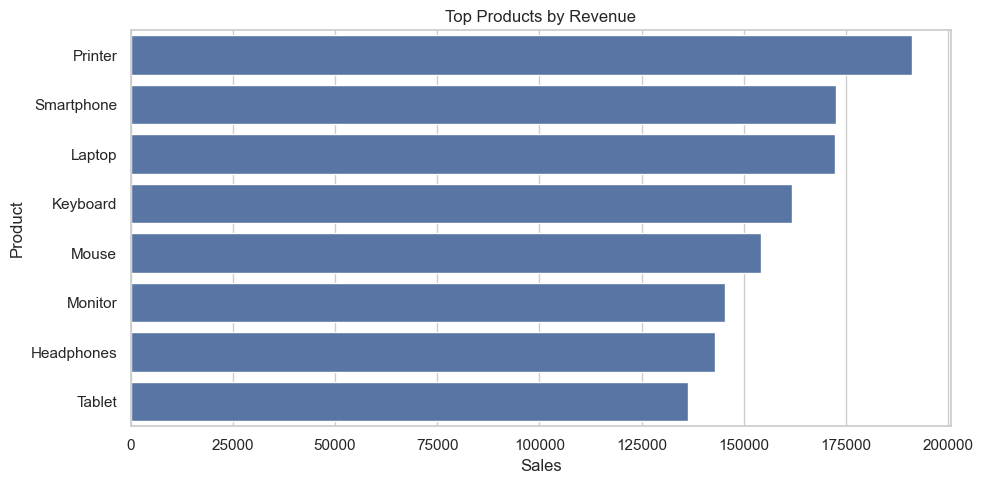

In [41]:
# Top products by revenue
top_products = df.groupby('Product')['Sales'].sum().sort_values(ascending=False).reset_index()
top_products.head(10)

# Plot top 10 products
plt.figure(figsize=(10,5))
sns.barplot(data=top_products.head(10), x='Sales', y='Product')
plt.title("Top Products by Revenue")
plt.tight_layout()
plt.savefig('Top Product Revenue By Bar Chat.png',dpi=300,bbox_inches='tight')
plt.show()

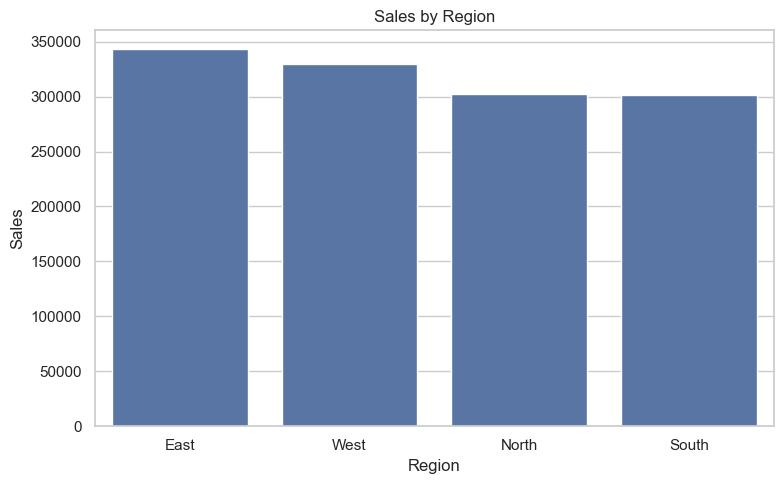

In [42]:
# Sales by Region
sales_region = df.groupby('Region')['Sales'].sum().sort_values(ascending=False).reset_index()
sales_region

# Plot Sales by Region
plt.figure(figsize=(8,5))
sns.barplot(data=sales_region, x='Region', y='Sales')
plt.title("Sales by Region")
plt.tight_layout()
plt.savefig('Sales by Region.png',dpi=300,bbox_inches='tight')
plt.show()



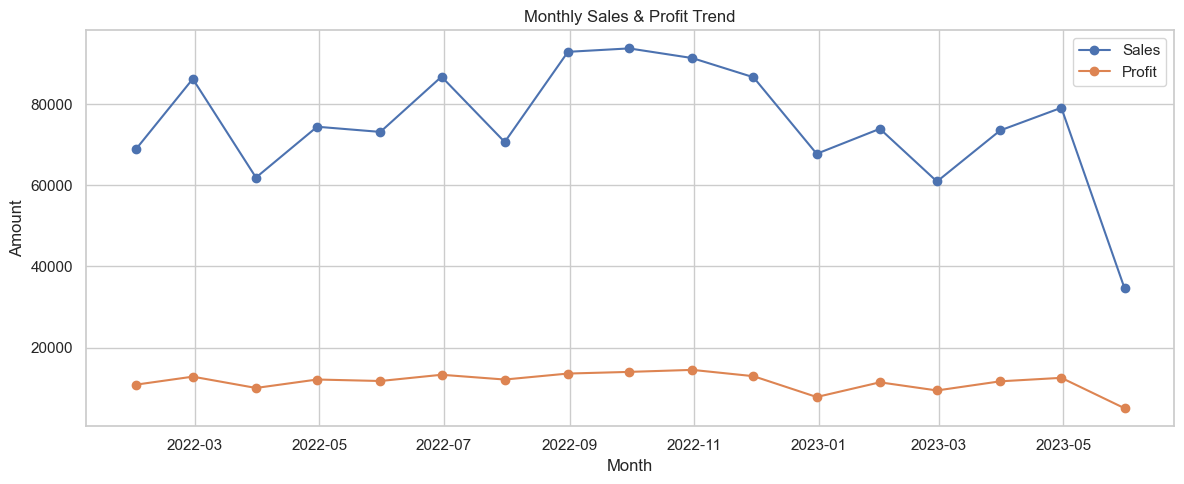

In [43]:
# Monthly sales trend (time series)
monthly_sales = df.set_index('OrderDate').resample('ME')['Sales'].sum()
monthly_profit = df.set_index('OrderDate').resample('ME')['Profit'].sum()

plt.figure(figsize=(12,5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', label='Sales')
plt.plot(monthly_profit.index, monthly_profit.values, marker='o', label='Profit')

plt.title("Monthly Sales & Profit Trend")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.legend()
plt.tight_layout()
plt.savefig('Monthly Sales & Profit Trend graph chat.png',dpi=300,bbox_inches='tight')
plt.show()


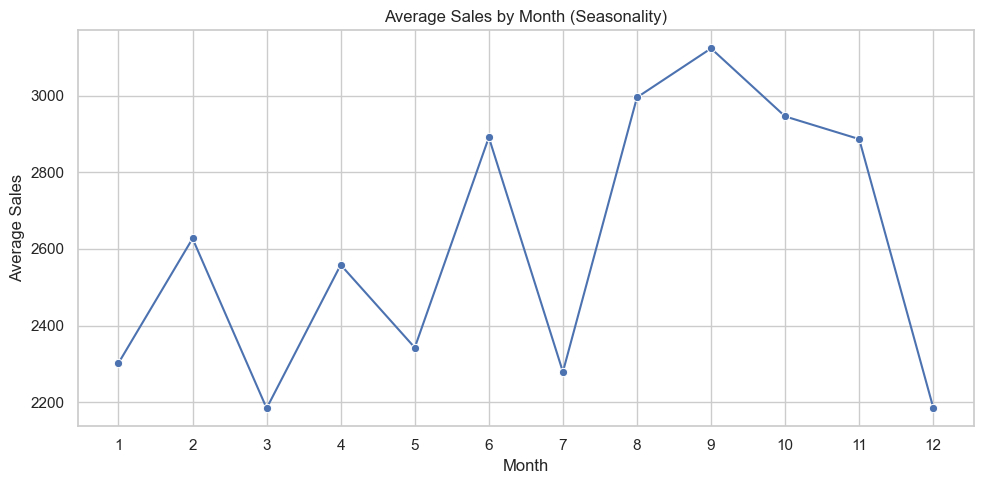

In [44]:
# Seasonality: average sales by month (Jan..Dec)
avg_by_month = df.groupby(df['OrderDate'].dt.month)['Sales'].mean().reindex(range(1,13))
plt.figure(figsize=(10,5))
sns.lineplot(x=avg_by_month.index, y=avg_by_month.values, marker='o')
plt.xticks(range(1,13))
plt.title("Average Sales by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.savefig('Average Sales by Month (Seasonality).png',dpi=300,bbox_inches='tight')
plt.show()


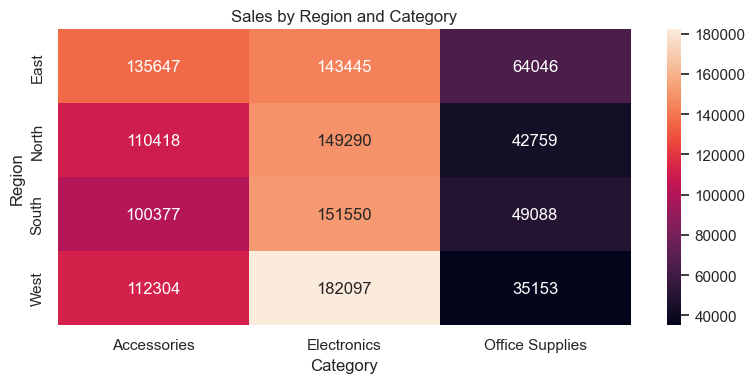

In [45]:
# Region x Category heatmap (pivot)
pivot = df.pivot_table(index='Region', columns='Category', values='Sales', aggfunc='sum').fillna(0)
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("Sales by Region and Category")
plt.tight_layout()
plt.savefig('Sales by Region and Category_ Heatmap.png',dpi=300,bbox_inches='tight')
plt.show()


In [16]:
#  Save aggregated outputs for reporting
top_products.to_csv("top_products_by_revenue.csv", index=False)
sales_region.to_csv("sales_by_region.csv", index=False)
monthly_sales.to_csv("monthly_sales.csv")
print("Saved top_products_by_revenue.csv, sales_by_region.csv, monthly_sales.csv")


Saved top_products_by_revenue.csv, sales_by_region.csv, monthly_sales.csv


In [29]:
#  Load into SQLite and run SQL queries
conn = sqlite3.connect("sales.db")
df.to_sql('sales', conn, if_exists='replace', index=False)
print("Saved dataframe to SQLite database sales.db (table: sales)")


Saved dataframe to SQLite database sales.db (table: sales)


In [47]:
# Cell 13 — Example SQL queries (run using pandas.read_sql_query)
# 1) Total sales per category
q1 = "SELECT Category, SUM(Sales) AS TotalSales FROM sales GROUP BY Category ORDER BY TotalSales DESC;"
print(pd.read_sql_query(q1, conn))

# 2) Month with maximum sales (using SQLite strftime)
q2 = "SELECT strftime('%Y-%m', OrderDate) as Month, SUM(Sales) as TotalSales FROM sales GROUP BY Month ORDER BY TotalSales DESC LIMIT 1;"
print(pd.read_sql_query(q2, conn))

# 3) Average profit margin per product (profit / sales)
q3 = "SELECT Product, AVG(Profit*1.0/Sales) as AvgProfitMargin FROM sales GROUP BY Product ORDER BY AvgProfitMargin DESC;"
print(pd.read_sql_query(q3, conn))

          Category  TotalSales
0      Electronics      626382
1      Accessories      458746
2  Office Supplies      191046
     Month  TotalSales
0  2022-04      153509
      Product  AvgProfitMargin
0     Printer         0.160598
1     Monitor         0.159044
2  Smartphone         0.155518
3  Headphones         0.154088
4       Mouse         0.153813
5      Laptop         0.149626
6      Tablet         0.147567
7    Keyboard         0.135558


In [19]:
# Cell 14 — Top 3 products by revenue IN EACH REGION
# Approach A: If your SQLite supports window functions (newer versions)
try:
    q4 = """
    SELECT Region, Product, TotalSales FROM (
      SELECT Region, Product, SUM(Sales) as TotalSales,
             ROW_NUMBER() OVER (PARTITION BY Region ORDER BY SUM(Sales) DESC) as rn
      FROM sales
      GROUP BY Region, Product
    ) WHERE rn <= 3;
    """
    top3_each_region = pd.read_sql_query(q4, conn)
    print("Top 3 products per region (window function):")
    print(top3_each_region)
except Exception as e:
    print("Window function method failed:", e)
    # Approach B: use pandas fallback
    print("\nUsing pandas fallback to get top 3 per region:")
    top3_per_region = df.groupby(['Region','Product'])['Sales'].sum().reset_index()
    top3_per_region = top3_per_region.sort_values(['Region','Sales'], ascending=[True, False])
    top3_per_region = top3_per_region.groupby('Region').head(3)
    print(top3_per_region)


Top 3 products per region (window function):
Empty DataFrame
Columns: [Region, Product, TotalSales]
Index: []


In [30]:
# Cell 15 — Simple forecasting
# We'll prepare monthly_sales (already computed). We'll create two simple forecasts:
# A) 3-month moving average (naive)
# B) Linear trend extrapolation using numpy.polyfit

monthly_sales = monthly_sales.sort_index()
forecast_periods = 3

# A) Moving average forecast (use last rolling mean)
rolling_window = 3
moving_avg = monthly_sales.rolling(window=rolling_window).mean()
naive_forecast_value = moving_avg.dropna().iloc[-1] if not moving_avg.dropna().empty else monthly_sales.iloc[-1]
naive_forecast = [naive_forecast_value] * forecast_periods

# B) Linear trend forecast
x = np.arange(len(monthly_sales))
y = monthly_sales.values
coeffs = np.polyfit(x, y, 1)  # degree 1 linear fit
trend = np.poly1d(coeffs)
future_x = np.arange(len(monthly_sales), len(monthly_sales) + forecast_periods)
linear_forecast = trend(future_x)

# Create forecast index (next months)
last_month = monthly_sales.index[-1]
future_index = [ (last_month + pd.DateOffset(months=i)).to_period('M').to_timestamp() for i in range(1, forecast_periods+1) ]

# Show combined dataframe
forecast_df = pd.DataFrame({
    'Date': future_index,
    'Naive_MA_Forecast': naive_forecast,
    'Linear_Trend_Forecast': linear_forecast
})
forecast_df.set_index('Date', inplace=True)
print(forecast_df)


            Naive_MA_Forecast  Linear_Trend_Forecast
Date                                                
2023-06-01            62402.0           67464.676471
2023-07-01            62402.0           66619.745098
2023-08-01            62402.0           65774.813725


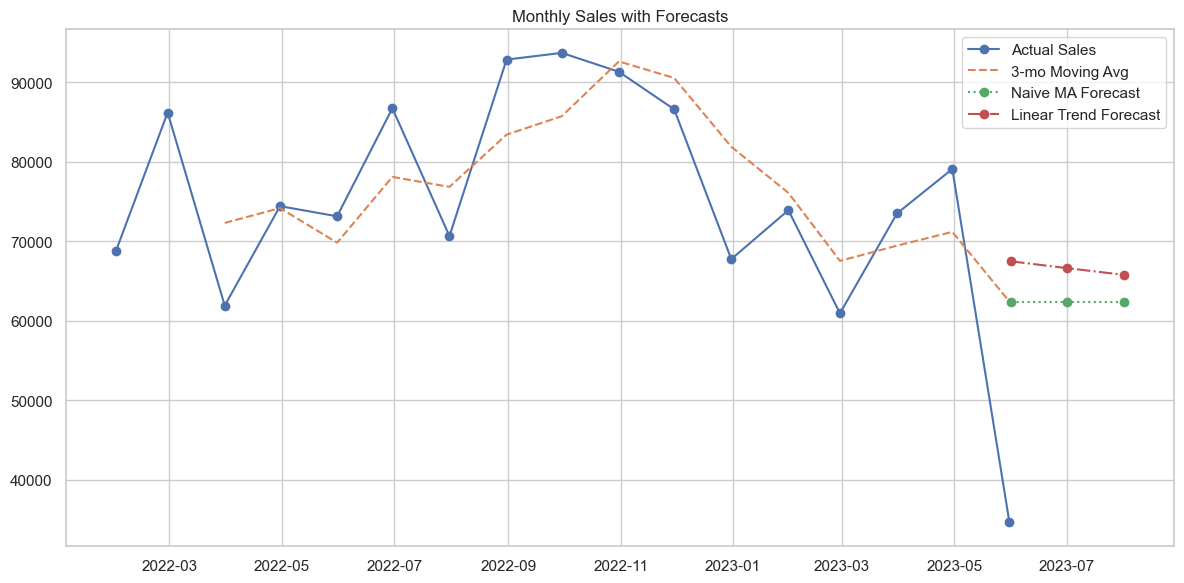

In [48]:
# Cell 16 — Plot actual + forecasts
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', label='Actual Sales')
plt.plot(moving_avg.index, moving_avg.values, label=f'{rolling_window}-mo Moving Avg', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Naive_MA_Forecast'], marker='o', linestyle=':', label='Naive MA Forecast')
plt.plot(forecast_df.index, forecast_df['Linear_Trend_Forecast'], marker='o', linestyle='-.', label='Linear Trend Forecast')
plt.title("Monthly Sales with Forecasts")
plt.legend()
plt.tight_layout()
plt.savefig('Monthly Sales with Forecasts',dpi=300,bbox_inches='tight')
plt.show()


In [31]:
# Cell 17 — Save forecast to CSV
forecast_df.to_csv("sales_forecast.csv")
print("Forecast saved to sales_forecast.csv")


Forecast saved to sales_forecast.csv


In [23]:
# Cell 18 — Wrap-up: save a short summary report (as simple text)
with open("report_summary.txt", "w") as f:
    f.write("Sales Data Analysis Summary\n")
    f.write("===========================\n")
    f.write(f"Total Sales: {total_sales}\n")
    f.write(f"Total Profit: {total_profit}\n")
    f.write("\nTop 5 Products by Revenue:\n")
    f.write(top_products.head(5).to_string(index=False))
print("report_summary.txt created")


report_summary.txt created


In [ ]:
#SQL COMMANDS 

In [35]:
# Example 1: Total sales per category
query1 = """
SELECT Category, SUM(Sales) AS TotalSales
FROM sales
GROUP BY Category
ORDER BY TotalSales DESC;
"""
result1 = pd.read_sql_query(query1, conn)
print(result1)


          Category  TotalSales
0      Electronics      626382
1      Accessories      458746
2  Office Supplies      191046


In [36]:
# Example 2: Month with maximum sales
query2 = """
SELECT strftime('%Y-%m', OrderDate) as Month, SUM(Sales) as TotalSales
FROM sales
GROUP BY Month
ORDER BY TotalSales DESC
LIMIT 1;
"""
result2 = pd.read_sql_query(query2, conn)
print(result2)


     Month  TotalSales
0  2022-04      153509


In [37]:
# Example 3: Average profit margin per product
query3 = """
SELECT Product, AVG(Profit*1.0/Sales) as AvgProfitMargin
FROM sales
GROUP BY Product
ORDER BY AvgProfitMargin DESC;
"""
result3 = pd.read_sql_query(query3, conn)
print(result3)


      Product  AvgProfitMargin
0     Printer         0.160598
1     Monitor         0.159044
2  Smartphone         0.155518
3  Headphones         0.154088
4       Mouse         0.153813
5      Laptop         0.149626
6      Tablet         0.147567
7    Keyboard         0.135558


In [38]:
# Example 4: Top 3 products by revenue in each region (fallback pandas method)
query4 = """
SELECT Region, Product, SUM(Sales) as TotalSales
FROM sales
GROUP BY Region, Product
ORDER BY Region, TotalSales DESC;
"""
df_region_product = pd.read_sql_query(query4, conn)

# Get top 3 per region using pandas
top3_per_region = df_region_product.groupby('Region').head(3)
print(top3_per_region)


   Region     Product  TotalSales
0    East     Printer       64046
1    East       Mouse       52270
2    East  Headphones       46777
8   North    Keyboard       52474
9   North  Smartphone       46317
10  North      Laptop       45405
16  South  Smartphone       50569
17  South     Printer       49088
18  South     Monitor       44101
24   West      Laptop       72880
25   West       Mouse       46453
26   West      Tablet       41386
